In [1]:
import pandas as pd
from utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts,load_init_trainer
from DL_class import MultiModelTrainer, Trainer
from config import get_args
from save_results import build_results_df
from paths import folder_path,file_name,get_save_directory
import torch
from plotting import plot_k_fold_split

# ==== GET PARAMETERS ====
# Load config
model_name = 'STGCN'  #'CNN'
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification :
args.epochs = 2
args.K_fold = 5   # Means we will use the first fold for the Ray Tuning and the 5 other ones to get the metrics
if torch.cuda.is_available():
    args.device = 'cuda:0'
    args.batch_size = 256
    args.single_station = False
else :
    args.device = 'cpu'
    args.batch_size = 32
    args.single_station = True

args.ray = False

args.loss_function_type = 'quantile'  #'MSE' #

if args.loss_function_type == 'MSE':
    args.out_dim = 1
    args.alpha = None
    args.type_calendar = 'tuple'

else:
    args.embedding_dim = 3
    args.calendar_class = 3
    args.position = 'input'
    args.specific_lr = False
    args.type_calendar = 'tuple'
    args.out_dim = 2
    args.alpha = 0.1

# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0
split_limits.pkl has never been saved or issue with last .pkl save


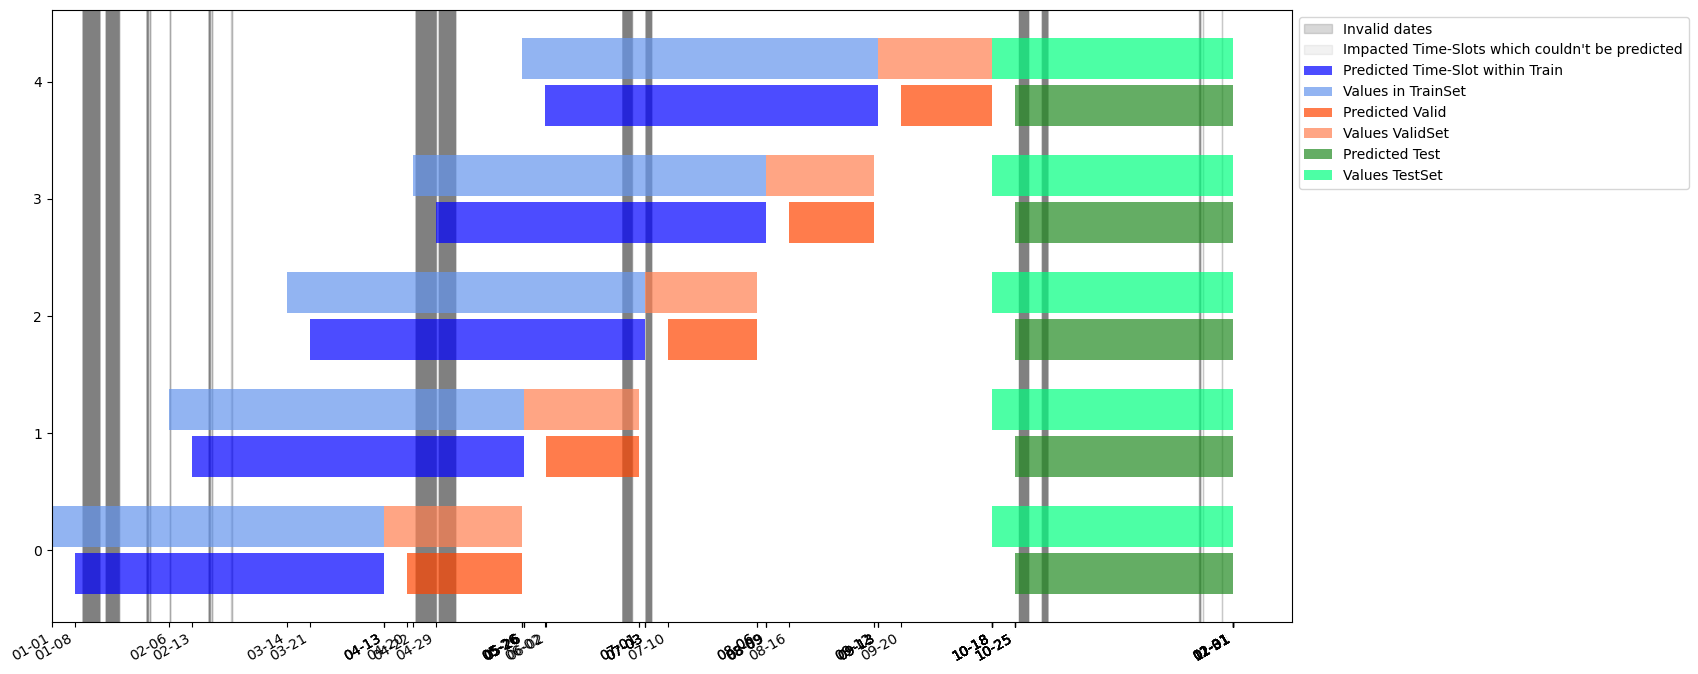

In [2]:
# Load dataset and invalid_dates
dataset,invalid_dates = get_DataSet_and_invalid_dates(args.abs_path,folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = False)

# Train / Valid / Test split and Normalize for K-fold 
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)

# Plot information about split and folds:
plot_k_fold_split(Datasets,invalid_dates)

In [ ]:
results_df = pd.DataFrame()
save_dir = get_save_directory(args)

multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_dir = save_dir,dic_class2rpz=dic_class2rpz)

(results_by_fold,mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation(mod_plot = 10)
results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")

# Svae results 
results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds)
results_df.to_csv(f"{args.model_name}_{args.loss_function_type}_H{args.H}_D{args.D}_W{args.W}_E{args.epochs}_K_fold{args.K_fold}_Emb_dim{args.embedding_dim}FC1_17_8_FC2_8_4_save_results.csv")

# Get Parameters : 

In [ ]:
# Load config
model_name = 'STGCN' #'CNN' 
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 1
args.K_fold = 1

args.loss_function_type = 'MSE'
args.out_dim = 1
args.alpha = None
# Save Directory:
main_dir = get_save_directory(args)

# Test complet sur les 3 Top STGCN, avec sauvegarde du model :

In [ ]:
results_df = pd.DataFrame()

#for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3,1,3],['input','input','input'],[True,True,False],['tuple','tuple','tuple'])):
for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3],['input'],[True],['tuple'])):

    args.calendar_class = calendar_class
    args.position = position
    args.specific_lr = specific_lr
    args.type_calendar = type_calendar

    save_dir = get_save_directory(args)

    # Load dataset and invalid_dates 
    dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = False)
    (Datasets,DataLoader_list,time_slots_labels,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)
    
    # Load associated K_folds Models: 
    (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz)
    multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_dir = save_dir,dic_class2rpz=dic_class2rpz)
    (results_by_fold,mean_picp,mean_mpiw,dict_last,dict_scores) = multimodeltrainer.K_fold_validation(mod_plot = 1)
    results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")
    
    # Svae results 
    results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last,dict_scores)
                            
results_df.to_csv('save_results.csv')
results_df

In [ ]:
# ==== GET PARAMETERS ====
# Load config
model_name = 'STGCN' #'CNN' 
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 300

# Save Directory:
main_dir = get_save_directory(args)
args.H = 0
args.W = 0
args.D = 0
args.L =args.H+args.W+args.D
args.single_station = True
# ==== TEST  ====
for K_fold in [5]:
    args.K_fold = K_fold
    results_df = pd.DataFrame()

    #for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3,1,3],['input','input','input'],[True,True,False],['tuple','tuple','tuple'])):
    #for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3],['input'],[True],['tuple'])):
    for i,(embedding_dim,calendar_class,position,specific_lr, type_calendar,time_embedding) in enumerate(zip([3], # None
                                                                                                             [3], # 3
                                                                                               ['input'], # None
                                                                                               [False], # None 
                                                                                               ['tuple'], # None
                                                                                               [True] # False
                                                                                              )
                                                                                            ):
        args.embedding_dim = embedding_dim
        args.calendar_class = calendar_class
        args.position = position
        args.specific_lr = specific_lr
        args.type_calendar = type_calendar
        args.time_embedding = time_embedding

        save_dir = get_save_directory(args)

        # Load dataset and invalid_dates 
        dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = args.single_station)
        (Datasets,DataLoader_list,time_slots_labels,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)

        # Load associated K_folds Models: 
        (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz)
        multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_dir = save_dir,dic_class2rpz=dic_class2rpz)
        
        (results_by_fold,mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation(mod_plot = 10)
        results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")

        # Svae results 
        results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds)
        results_df.to_csv(f"{args.model_name}_H{args.H}_D{args.D}_W{args.W}_E{args.epochs}_K_fold{args.K_fold}_Emb_dim{args.embedding_dim}FC1_17_8_FC2_8_4_save_results.csv")